# Pipeline for Ca-Data-Preprocessing and Analysis

# Calcium Imaging preprocessing
---
* Author: Yue Zhang and David Burkhardt (AG Arrenberg)
* date: 17/04/2023

In [1]:
# import libraries
from skimage import io
import os
import numpy as np
from PyQt5.QtWidgets import QFileDialog, QApplication

# from Exp4_for_test_data import * # use Exp4_for_test_data for running test data
from Exp4 import * # use Exp4 for running your own data

# %matplotlib notebook
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
working_dir = 'testdata_2024'
ca_filename = "ca_recording.tif"
timeline_filename = "Io.hdf5"
stimulus_filename = "Display.hdf5"

In [3]:
# load calcium data
ca_movie = load_ca_movie(os.path.join(working_dir, ca_filename))

## Registration

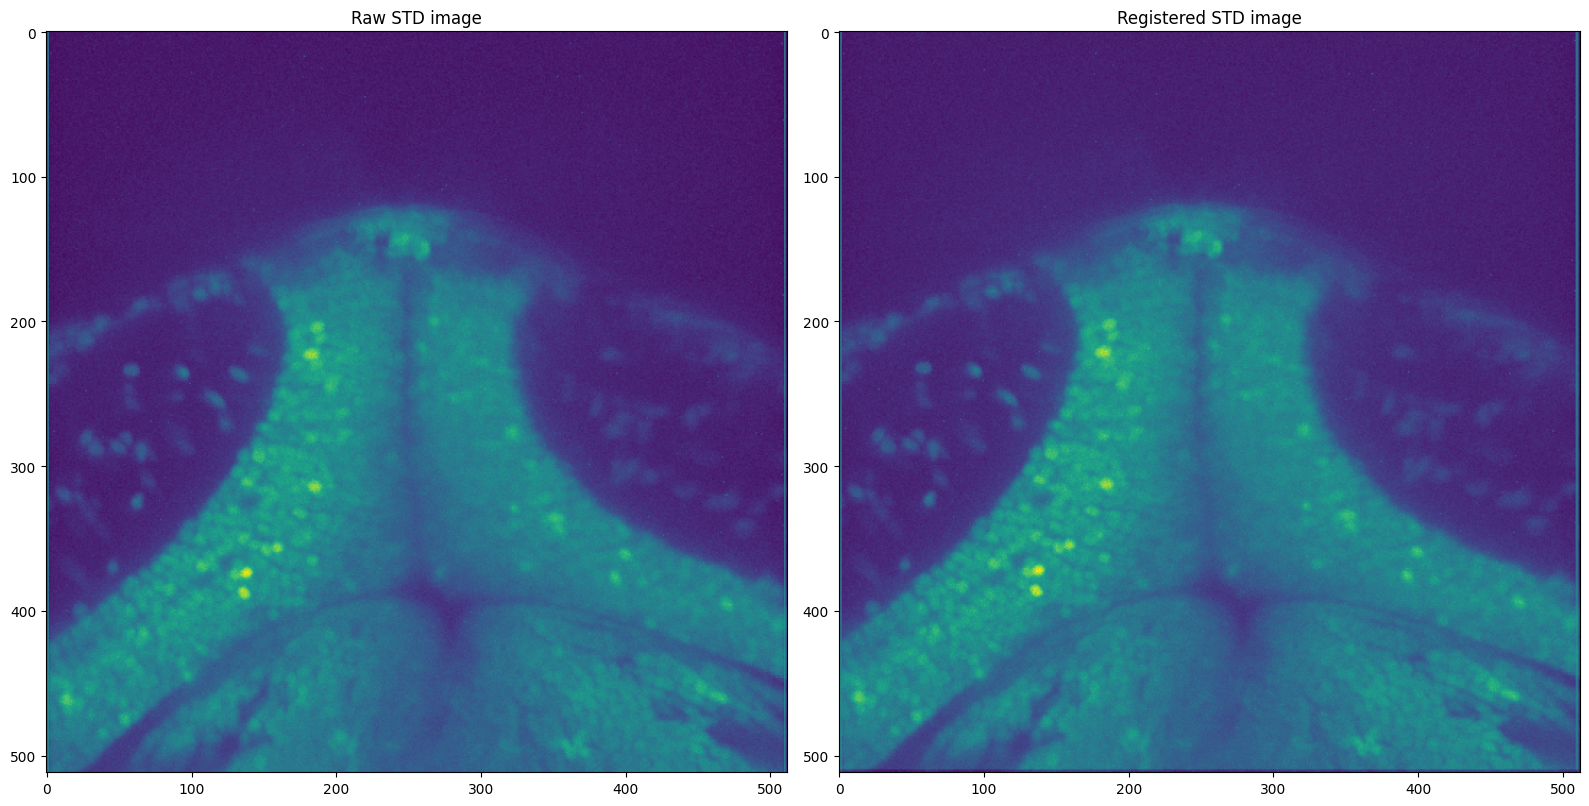

In [4]:
# registration (motion correction) of calcium frames and computation of STD image
reg_frames, std_image = motion_correction(ca_movie, binsize=100, stepsize=20)    #10, 10

## Cell Segmentation

C:\Users\timhl\PycharmProjects\preprocessing_arrenberg_practical_2022\Exp4.py:162: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  maxCoord = peak_local_max(smoothed_std_image, footprint=conn, indices=False, exclude_border=0)


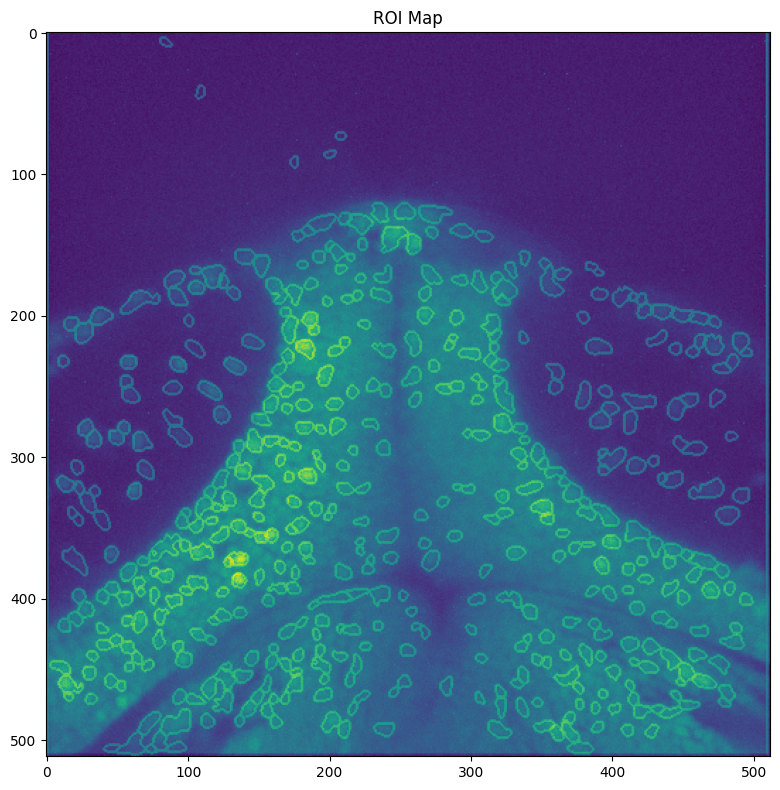

In [5]:
# cell (ROIs) segmentation with watershed algorithm
segmentation_params = {
    'hpfiltSig': .1,
    'localThreKerSize': 9,
    'smoothSig': 3,
    'binaryThre': .5,
    'minSizeLim': 20,
    'maxSizeLim': 500,
    'bgKerSize': 2,
    'fgKerSize': 1
    }
roi_mask = cell_segmentation(std_image, segmentation_params)

In [6]:
# extract calcium traces for ROIs
raw_ca_traces = extract_calcium_signals(roi_mask, reg_frames, display_traces=False)

# size of array
print(np.array(raw_ca_traces).shape)

(473, 871)


## DF/F Computation
compute DF/f for each calcium trace
* Hint: $\frac{\Delta F}{F} = \frac{F(t) - F_{0}}{F_{0}}$

In [7]:
raw_ca = np.array(raw_ca_traces)
dff_ca_traces = raw_ca # put your calculation here

## Stimulus Parameter Aquisition

Text(0.5, 0, '#frames')

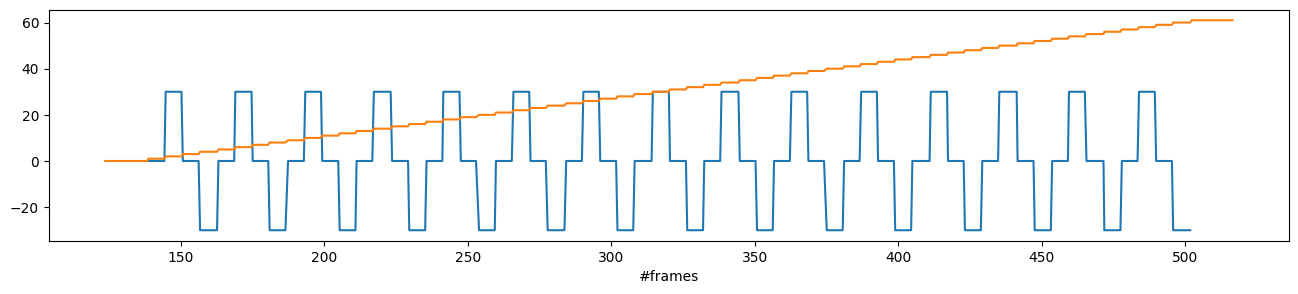

In [8]:
# acquire stimulus parameter for each calcium frames
io_file = os.path.join(working_dir, timeline_filename)
display_file = os.path.join(working_dir, stimulus_filename)
stim_array = align_stimulus_to_ca_frames(timefn=io_file,stim_fn=display_file)

# visualize
plt.figure(figsize=(16, 3))
plt.plot(stim_array['time'],stim_array['speed'])
plt.plot(stim_array['time'],stim_array['phase'])
plt.xlabel('#frames')
# plt.plot(stim_array['time'],stim_array['spatial_freq'])

In [9]:
stim_array

phase  speed  spatial_period        time
7      0.0    NaN             NaN  123.762833
8      0.0    NaN             NaN  124.235090
9      0.0    NaN             NaN  124.580138
10     0.0    NaN             NaN  125.165199
11     0.0    NaN             NaN  125.440234
..     ...    ...             ...         ...
859   61.0    NaN             NaN  514.578996
860   61.0    NaN             NaN  515.014060
861   61.0    NaN             NaN  515.489112
862   61.0    NaN             NaN  515.869154
863   61.0    NaN             NaN  516.414211

[854 rows x 4 columns]

In [10]:
# store ROIs and stimulus parameters  in one DataFrame
roi_id = np.unique(roi_mask)[1:]
formatted = pd.DataFrame(np.array(dff_ca_traces).T,columns=roi_id)
for k,v in stim_array.items():
    formatted["stim_"+k] = v
    
formatted = formatted[formatted['stim_phase'].notna()]
    
# visualize
# formatted.to_csv(working_dir + "test1.csv")
formatted

1         2         3         4         5         6         7  \
7   -0.212786  0.230492  0.333708  0.733575 -0.485028 -0.208693  0.060912   
8    0.352379  0.558026  0.076346 -0.537569 -0.171129 -0.167992 -0.233725   
9   -0.242236  0.364198  0.123542 -0.567822  0.156912 -0.193385 -0.342084   
10   0.256079  0.989240 -0.105429 -0.014363  0.046224 -0.085021 -0.290185   
11  -0.432409  0.131323  0.177890 -0.373274  0.382248 -0.060415 -0.180458   
..        ...       ...       ...       ...       ...       ...       ...   
859 -0.054657  0.928783  0.149573  0.387765 -0.555488  0.273979 -0.043182   
860  0.148903  0.204572  0.081066 -0.195946 -0.456868 -0.038791  0.060162   
861  0.569409 -0.357925 -0.417139 -0.459777 -0.227510  0.012123  0.002424   
862 -0.386895 -0.157500  0.177964 -0.384078  1.144933  0.095517  0.175637   
863  0.036289  0.308117 -0.046509  0.130484  0.682067  0.163505 -0.090183   

            8         9        10  ...       468       469       470  \
7   -0.168444 -0.080781 -0.003993  ... -0.103320  0.056080  0.018640   
8   -0.255617 -0.467136 -0.274096  ... -0.104478  0.629702  0.062285   
9   -0.060286  0.126624 -0.014175  ... -0.147068 -0.367824  0.087574   
10  -0.133501  0.333062 -0.108234  ... -0.041718 -0.112881  0.010164   
11  -0.310985 -0.109333 -0.147445  ... -0.381168  0.178496 -0.098927   
..        ...       ...       ...  ...       ...       ...       ...   
859 -0.114825  0.156616 -0.117223  ...  0.206706 -0.651112 -0.075143   
860 -0.176315 -0.138572 -0.095656  ...  0.018143 -0.400214  0.019099   
861 -0.141265  0.186199 -0.037779  ... -0.374708  0.311023 -0.045302   
862 -0.131385  0.104294 -0.086322  ... -0.196142  0.595259 -0.073775   
863  0.148983  0.111516  0.019605  ... -0.236354  0.043914  0.063364   

          471       472       473  stim_phase  stim_speed  \
7   -0.377832  0.314120  0.214517         0.0         NaN   
8   -0.209694 -0.164818  0.190183         0.0         NaN   
9    0.441505  0.138590  0.328802         0.0         NaN   
10   0.519189 -0.239493 -0.199955         0.0         NaN   
11   0.252893 -0.284213 -0.047898         0.0         NaN   
..        ...       ...       ...         ...         ...   
859 -0.645862 -0.283116 -0.106213        61.0         NaN   
860  0.027571  0.154497  0.199601        61.0         NaN   
861 -0.286579 -0.156311 -0.000479        61.0         NaN   
862  0.607084 -0.433885  0.039725        61.0         NaN   
863  0.459340 -0.318947  0.041813        61.0         NaN   

     stim_spatial_period   stim_time  
7                    NaN  123.762833  
8                    NaN  124.235090  
9                    NaN  124.580138  
10                   NaN  125.165199  
11                   NaN  125.440234  
..                   ...         ...  
859                  NaN  514.578996  
860                  NaN  515.014060  
861                  NaN  515.489112  
862                  NaN  515.869154  
863                  NaN  516.414211  

[854 rows x 477 columns]

Text(0, 0.5, '#ROIs')

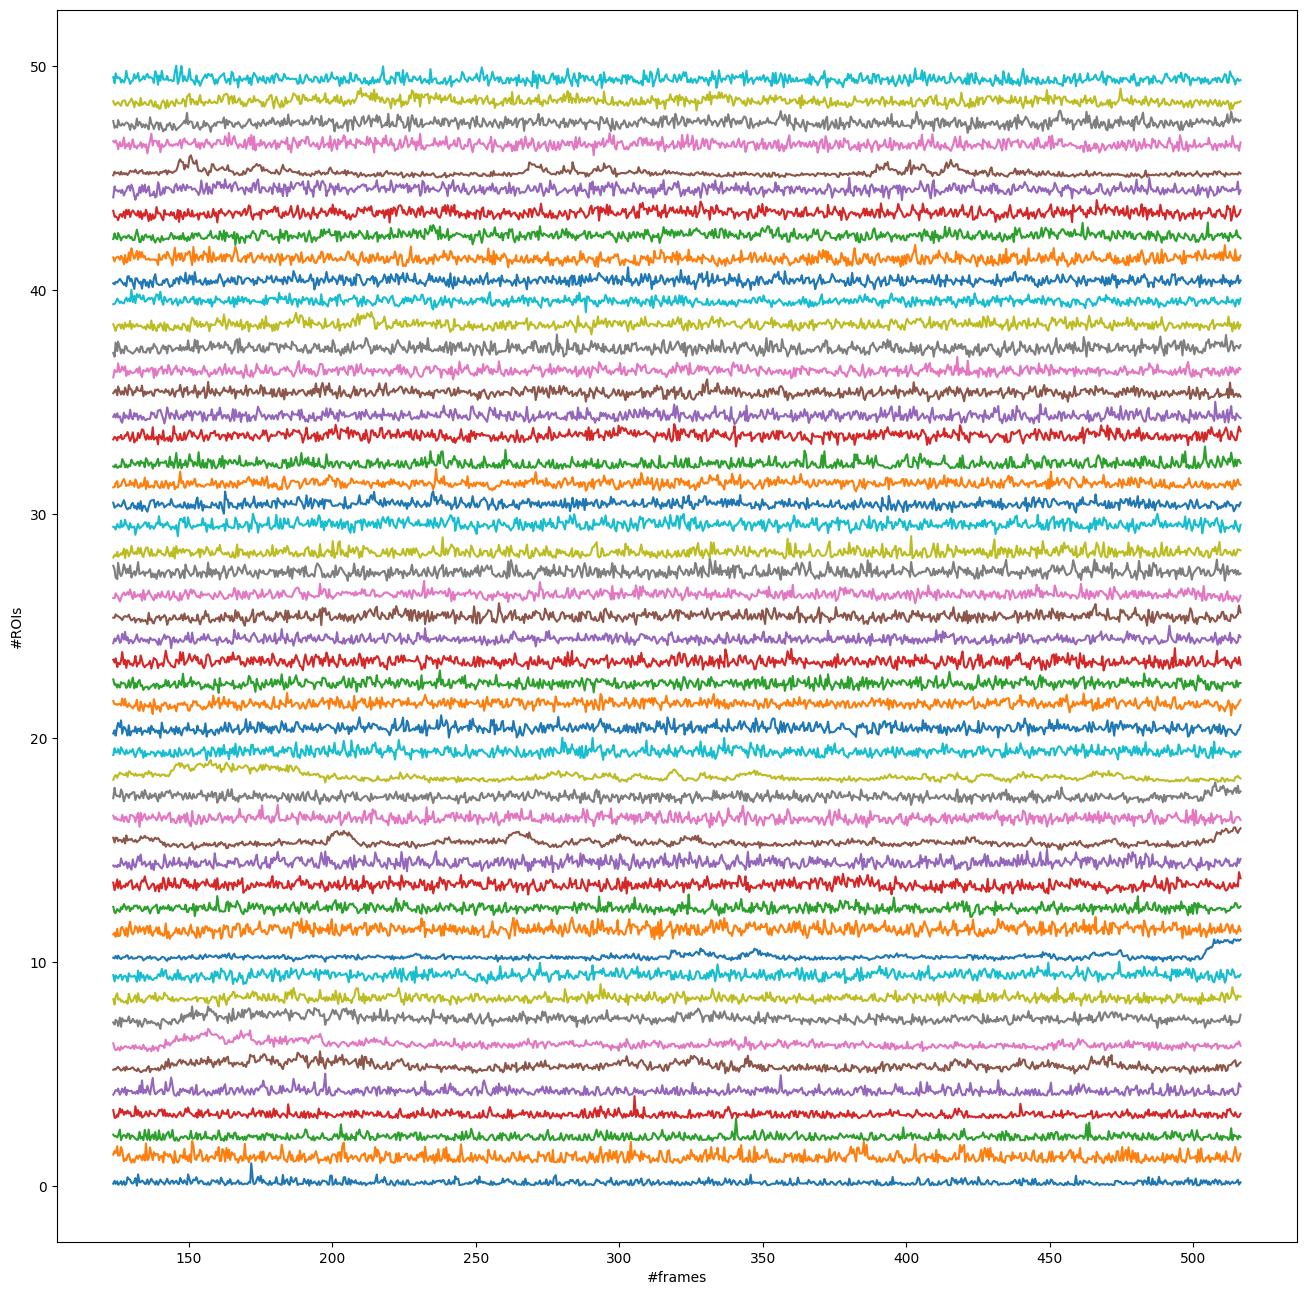

In [11]:
# plot some example calcium traces
plt.figure(figsize=(16, 16))
for i in range(50):
    plt.plot(formatted['stim_time'],rnorm(formatted[i+1].to_numpy())+i)
plt.xlabel('#frames')
plt.ylabel('#ROIs')

## ROI Analysis

Text(0.5, 0, 'time [s]')

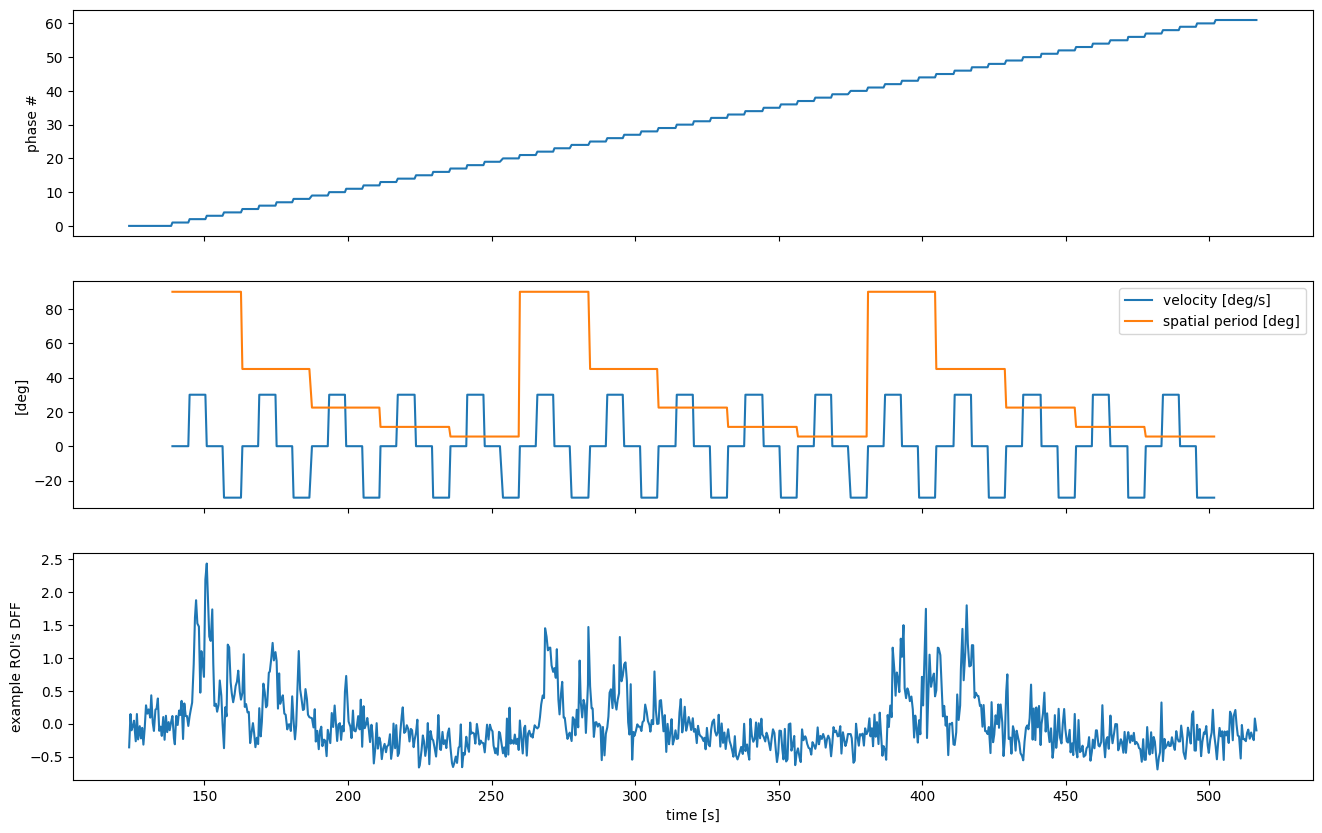

In [12]:
# visualization of stimulus phase, velocity and a example ROI
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
axes[0].plot(formatted['stim_time'], formatted['stim_phase'])
axes[0].set_ylabel('phase #')

axes[1].plot(formatted['stim_time'], formatted['stim_speed'], label='velocity [deg/s]')
axes[1].plot(formatted['stim_time'], formatted['stim_spatial_period'], label='spatial period [deg]')
axes[1].set_ylabel('[deg]')
axes[1].legend()

axes[2].plot(formatted['stim_time'], formatted[46])
axes[2].set_ylabel('example ROI\'s DFF')

axes[2].set_xlabel('time [s]')

### Calculate mean/sum of DFF for each stimulation phase

In [13]:
# put your calculation here

### Calculate auto-correlation between stimulus repeats

In [14]:
# put your calculation here

### Calculate correlation between mean phase-DFF and stimulus regressors

$kernel = e^{\frac{-t}{\tau}}$

NameError: name 'kernel' is not defined

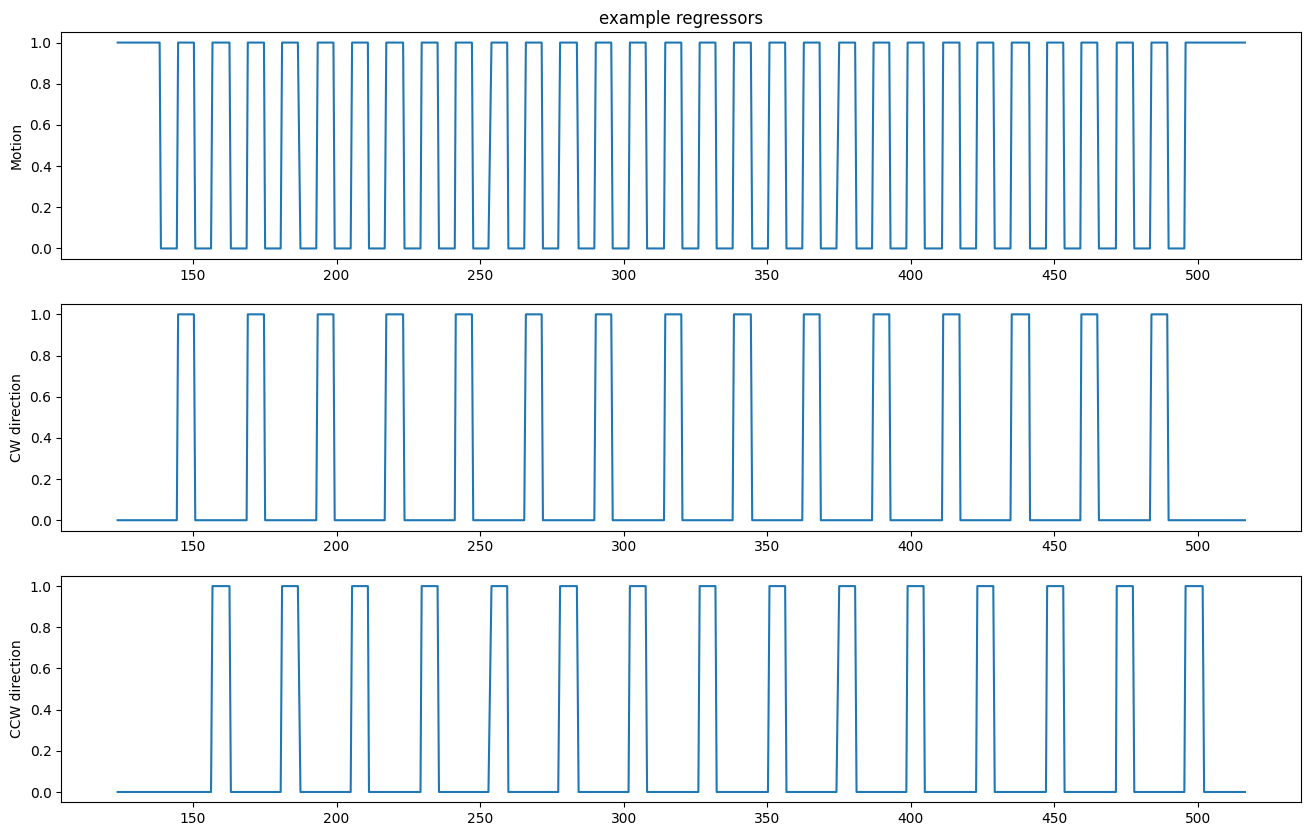

In [15]:
tau = 1.61
ca_times = formatted['stim_time']
# ktimes = np.arange(-7, 7, np.mean(np.diff(ca_times)))
# kernel = np.zeros_like(ktimes)
# kernel[ktimes >= 0] = np.exp(-ktimes[ktimes >= 0]/tau) / 3.
#
# plt.figure()
# plt.plot(ktimes, kernel)


# example plots for different regressors
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

axes[0].set_title('example regressors')

motion = (formatted['stim_speed'] != 0).astype(np.float64)
axes[0].plot(ca_times, motion)
axes[0].set_ylabel('Motion')

cw_motion = (formatted['stim_speed'] > 0).astype(np.float64)
axes[1].plot(ca_times, cw_motion)
axes[1].set_ylabel('CW direction')

ccw_motion = (formatted['stim_speed'] < 0).astype(np.float64)
axes[2].plot(ca_times, ccw_motion)
axes[2].set_ylabel('CCW direction')

axes[0].plot(ca_times, np.convolve(motion, kernel, mode='same'), '--')
axes[1].plot(ca_times, np.convolve(cw_motion, kernel, mode='same'), '--')
axes[2].plot(ca_times, np.convolve(ccw_motion, kernel, mode='same'), '--')

axes[2].set_xlabel('time [s]')

In [ ]:
# put your calculation here